In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb

In [2]:
df = pd.read_csv('../data/V2_BPD_CRIME_DATA_ENCODED.csv')


In [3]:
df.head()


,Unnamed: 0,CrimeDate,Description,Neighborhood,Premise,Month,Hour,Outside,Weapon_FIREARM,Weapon_HANDS,Weapon_KNIFE,Weapon_NONE,Weapon_OTHER,Holiday,Weekend
0,0,2017-09-02,11,26,69,9,23,0,0,0,1,0,0,0,1
1,1,2017-09-02,3,213,78,9,23,1,0,0,0,1,0,0,1
2,2,2017-09-02,14,267,78,9,22,1,1,0,0,0,0,0,1
3,3,2017-09-02,0,37,69,9,22,0,0,0,0,0,1,0,1
4,4,2017-09-02,5,63,78,9,22,1,0,1,0,0,0,0,1


In [3]:
df = df.drop(columns=["Unnamed: 0","CrimeDate"])

In [4]:
X = df.drop(columns = ['Description'])
Y = df['Description']


Let's see how this works with a basic random forest.

In [1]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from mlflow.models.signature import infer_signature
import mlflow.lightgbm

In [6]:
from sklearn.model_selection import cross_val_score


In [8]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model

  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]


In [9]:
with mlflow.start_run(run_name='random_forest_test'):
  n_estimators = 50
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=42069)
  model.fit(X, Y)

  scores = cross_val_score(model, X, Y, cv=5, scoring='f1_macro', n_jobs=-1)
  mlflow.log_param('n_estimators', n_estimators)

  mlflow.log_metric('f1_macro', np.mean(scores))
  wrappedModel = SklearnModelWrapper(model)
  signature = infer_signature(X, wrappedModel.predict(None, X))
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, signature=signature)


c:\users\administrator\documents\github\dazed-confusion-matrix\venv\lib\site-packages\mlflow\models\signature.py:123: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [13]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)


,importance
Neighborhood,0.332721
Weapon_HANDS,0.133689
Premise,0.126193
Weapon_NONE,0.103594
Hour,0.097661
Month,0.076429
Outside,0.052585
Weapon_OTHER,0.027910
Weapon_FIREARM,0.027049
Weapon_KNIFE,0.015338


Let's see if we can do this without saving a model.

In [10]:
with mlflow.start_run(run_name='random_forest_test_no_model'):
  n_estimators = 100
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=42069)
  model.fit(X, Y)

  scores = cross_val_score(model, X, Y, cv=5, scoring='f1_macro', n_jobs=-1)
  mlflow.log_param('n_estimators', n_estimators)

  mlflow.log_metric('f1_macro', np.mean(scores))


To access the results, open terminal and type mlflow ui in the directory where the mlruns is located. In this case cd to Model_Development


In [11]:
with mlflow.start_run(run_name="Untuned_lightgbm_test_2"):
    n_estimators = 100
    num_leaves = 32
    model = lgb.LGBMClassifier(objective='multiclass',num_class=15,
                         random_state=42069, silent=True,
                         n_jobs=-1, n_estimators=n_estimators, num_leaves=num_leaves)
    scores = cross_val_score(model, X, Y, cv=5, scoring='f1_macro', n_jobs=-1)

    mlflow.log_param("n_estimators", n_estimators)

    mlflow.log_metric("f1_macro", np.mean(scores))


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

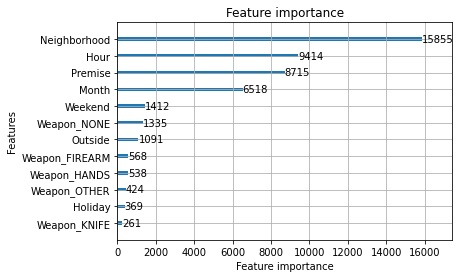

In [12]:
model.fit(X,Y)
lgb.plot_importance(model)


In [7]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope


Let's try some fancy hyperopt stuff.


In [18]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 20,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 200, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50,1)),
    'reg_alpha': hp.loguniform('reg_l1', -6, 7),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',4,30,1)),
    'objective': "multiclass",
    "random_state": 42069,
    "n_jobs": -1,
    "silent": True,
    "num_class": 15,
    "boosting": hp.choice("boosting",["gbdt", "dart", "goss"])
}

In [9]:
def train_model(params):
    mlflow.lightgbm.autolog()
    with mlflow.start_run(nested=True):
        booster = lgb.LGBMClassifier()
        booster.set_params(**params)
        booster.fit(X,Y)

        mlflow.log_params(params)

        score = cross_val_score(booster, X, Y, cv=5, scoring='f1_macro', n_jobs=-1)
        mean_score = np.mean(score)

        mlflow.log_metric('f1_macro', mean_score)

        return {'status': STATUS_OK, 'loss': -1*mean_score, 'booster': booster.get_params()}

In [20]:
with mlflow.start_run(run_name='lightgbm_models_test'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )

100%|██████████| 5/5 [05:09<00:00, 61.91s/trial, best loss: -0.3905026519134033]


Cool. We need to modify the min_child_weight to be between 0.01 and 250

In [27]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 20,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 4, 200, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50,1)),
    'reg_alpha': hp.loguniform('reg_l1', -10, 7),
    'min_child_weight': hp.loguniform('min_child_weight', -4.6, 5.53),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',4,30,1)),
    'objective': "multiclass",
    "random_state": 42069,
    "n_jobs": -1,
    "silent": True,
    "num_class": 15,
    "boosting": hp.choice("boosting",["gbdt", "dart", "goss"]),
    "class_weight": hp.choice("class_weight",["balanced",None])

}


In [28]:
def train_model(params):
    mlflow.lightgbm.autolog()
    with mlflow.start_run(nested=True):
        booster = lgb.LGBMClassifier()
        booster.set_params(**params)
        booster.fit(X,Y)

        mlflow.log_params(params)

        score = cross_val_score(booster, X, Y, cv=5, scoring='f1_macro', n_jobs=-1)
        mean_score = np.mean(score)

        mlflow.log_metric('f1_macro', mean_score)

        return {'status': STATUS_OK, 'loss': -1*mean_score, 'booster': booster.get_params()}


In [29]:
with mlflow.start_run(run_name='lightgbm_models_first_run'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )

100%|██████████| 100/100 [1:05:40<00:00, 39.40s/trial, best loss: -0.39406431370333905]


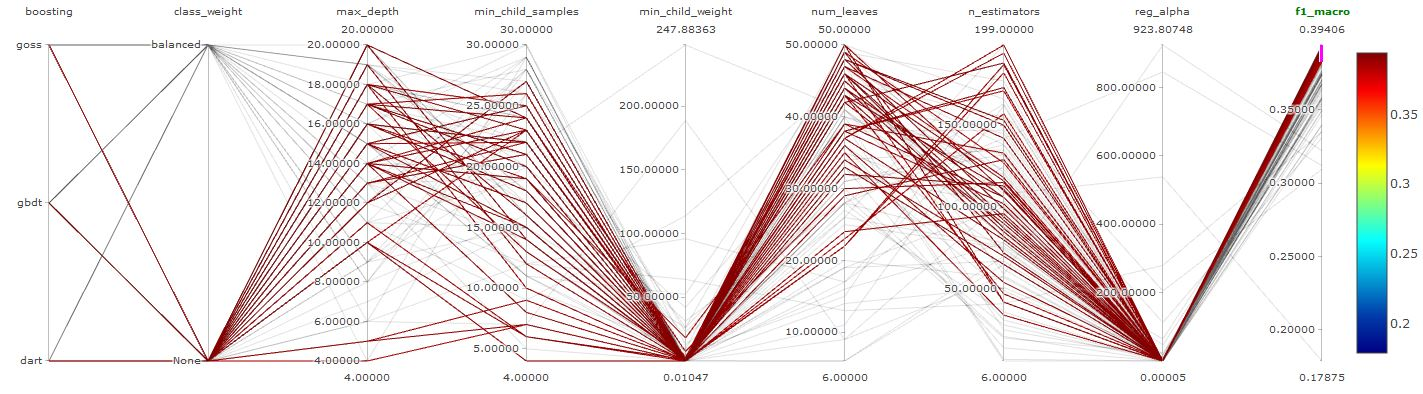

In [31]:
from IPython.display import Image
Image(filename='../images/Initial_hyperopt.JPG')


So here we can clearly see that the better models tend to have low min_child_weight values, as well as low l1_reg (alpha). Also we can remove the class_weight hyperparameter as all the "balanced" ones are bad. Dart also tends to perform poorly in comparison to the other boosters (apparent if I move the bar a bit higher)

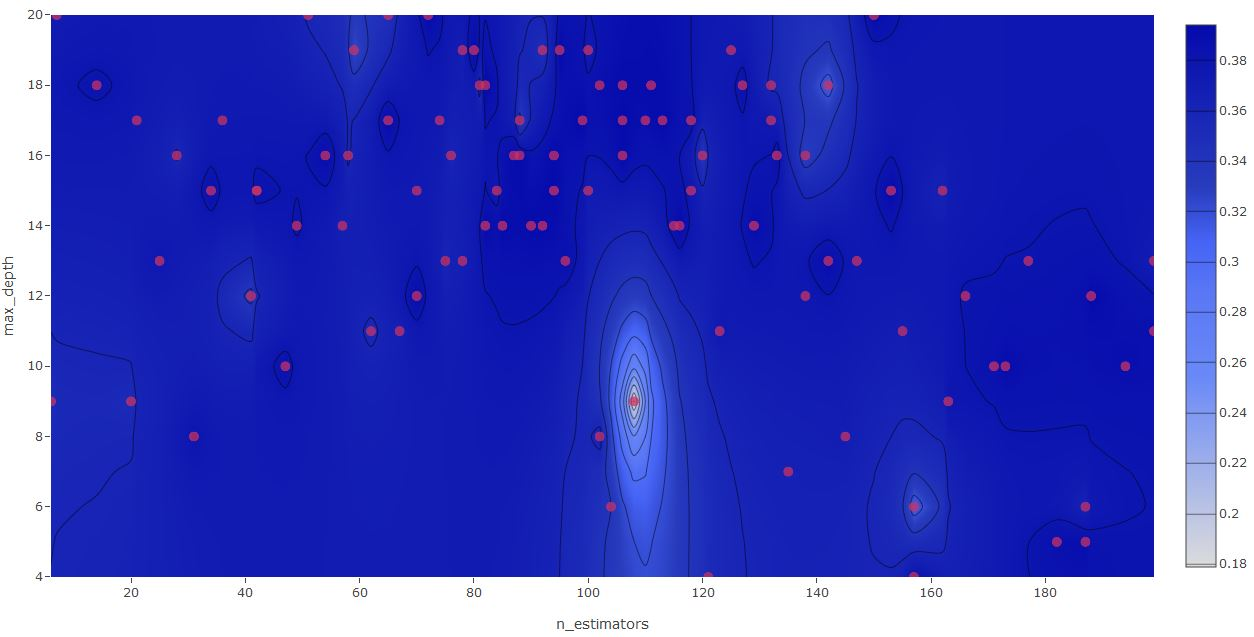

In [33]:
Image(filename='../images/initial_contour_plot.JPG')


The contour plot can show the areas where two hyperparameters interact for a higher metric. In this case the graph is pretty boring, but does give us an idea that a higher max_depth is better. But if we plot anything with the L1 reg, we see that higher values of L1 perform poorly, which we already knew from the 1st graph.

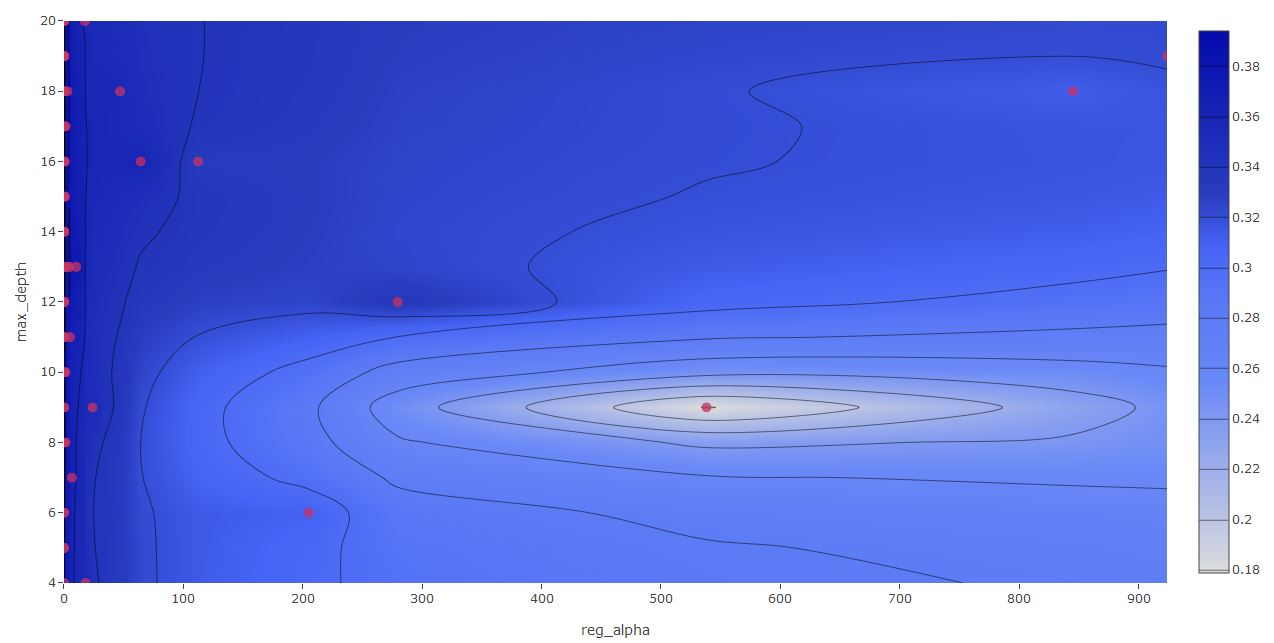

In [34]:
Image(filename='../images/higher_L1_is_bad.JPG')


Let's hone in on a few of the hyperparameters.

In [35]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 30,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 20, 1000, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 20, 100,1)),
    'reg_alpha': hp.loguniform('reg_l1', -10, 0),
    'min_child_weight': hp.loguniform('min_child_weight', -4.7, 2.7),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',4,30,1)),
    'objective': "multiclass",
    "random_state": 42069,
    "n_jobs": -1,
    "num_class": 15,
    "boosting": hp.choice("boosting",["gbdt", "goss"]),
}

In [36]:
with mlflow.start_run(run_name='lightgbm_models_second_run'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )


100%|██████████| 100/100 [5:55:42<00:00, 213.42s/trial, best loss: -0.3932332115248619]  


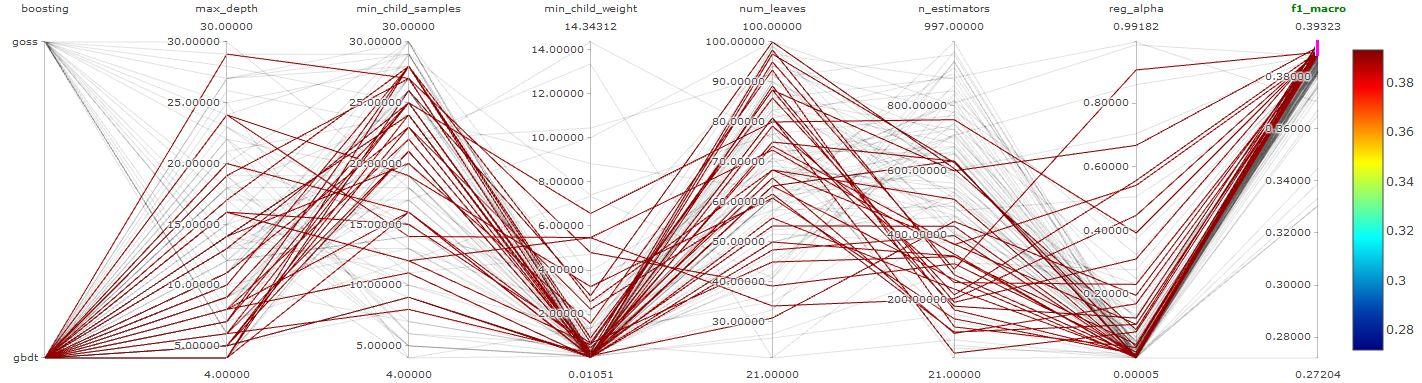

In [37]:
Image(filename='../images/Initial_hyperopt_2.JPG')


In [10]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 20,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 20, 650, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 200,1)),
    'reg_alpha': hp.uniform('reg_l1', 0, 0.6),
    'min_child_weight': hp.loguniform('min_child_weight', -10, 2.1),
    'min_child_samples': scope.int(hp.quniform('min_child_samples',4,30,1)),
    'objective': "multiclass",
    "random_state": 42069,
    "n_jobs": -1,
    "num_class": 15
}


In [11]:
with mlflow.start_run(run_name='lightgbm_models_third_run'):
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=Trials(),
    rstate=np.random.RandomState(42069)
  )


100%|██████████| 100/100 [2:40:52<00:00, 96.52s/trial, best loss: -0.39467223394102974]  


In [12]:
best_runs = pd.read_csv("../Model_Development/best_base_mode_runs.csv")


In [15]:
best_run = best_runs[best_runs["f1_macro"]==np.max(best_runs["f1_macro"])]

In [16]:
best_run


,Run ID,Name,Source Type,Source Name,User,Status,boosting,class_weight,max_depth,min_child_samples,min_child_weight,n_estimators,n_jobs,num_class,num_leaves,objective,random_state,reg_alpha,silent,f1_macro
0,7860c371779a408fb13dce66d2cafb41,NaN,LOCAL,c:\users\administrator\documents\github\dazed-...,Administrator,FINISHED,NaN,NaN,14,18,0.119925,85,-1,15,71,multiclass,42069,0.312058,NaN,0.394672


In [21]:
best_max_depth = best_run["max_depth"][0]
best_min_child_samples = best_run["min_child_samples"][0]
best_min_child_weight = best_run["min_child_weight"][0]
best_n_estimators = best_run["n_estimators"][0]
best_num_leaves = best_run["num_leaves"][0]
best_reg_alpha = best_run["reg_alpha"][0]

In [22]:
NEW_FINAL_MODEL = lgb.LGBMClassifier(random_state=42069, objective="multiclass", n_jobs=-1,num_class=15,
                                     max_depth=best_max_depth, min_child_samples=best_min_child_samples,
                                     min_child_weight=best_min_child_weight, n_estimators=best_n_estimators,
                                     num_leaves=best_num_leaves,reg_alpha=best_reg_alpha)

In [23]:
NEW_FINAL_MODEL.fit(X,Y)


LGBMClassifier(max_depth=14, min_child_samples=18,
               min_child_weight=0.1199252396895663, n_estimators=85,
               num_class=15, num_leaves=71, objective='multiclass',
               random_state=42069, reg_alpha=0.3120582452020382)

In [24]:
scores = cross_val_score(NEW_FINAL_MODEL, X, Y, cv=5, scoring='f1_macro', n_jobs=-1)


In [25]:
np.mean(scores)


0.39467223394102974

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

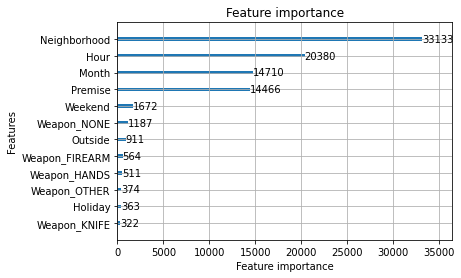

In [26]:
lgb.plot_importance(NEW_FINAL_MODEL)


In [27]:
NEW_FINAL_MODEL.booster_.save_model("BASE_MODEL_V2.txt")
